## TReNDS Neuroimaging

_Multiscanner normative age and assessments prediction with brain function, structure, and connectivity_

In this challenge, participants will predict age and assessment values from two domains using features derived from brain MRI images as inputs.

Models are expected to generalize on data from a different scanner/site (site 2). All subjects from site 2 were assigned to the test set, so their scores are not available. While there are fewer site 2 subjects than site 1 subjects in the test set, the total number of subjects from site 2 will not be revealed until after the end of the competition. To make it more interesting, the IDs of some site 2 subjects have been revealed below. Use this to inform your models about site effects. Site effects are a form of bias. To generalize well, models should learn features that are not related to or driven by site effects.

The .mat files for this competition can be read in python using h5py, and the .nii file can be read in python using nilearn.


In [1]:
### Use:
### -- RAPIDS
### -- cuml
### -- pycaret

### Problem Understanding

Neuroimaging specialists look for measurable markers of behavior, health, or disorder to help identify relevant brain regions and their contribution to typical or symptomatic effects.
<br />
An fMRI scan is a functional magnetic resonance imaging scan that measures and maps the brain’s activity by the bloodflow during scanning.

Separate, unrelated large imaging dataset was utilized to learn feature templates. Then, these templates were "projected" onto the original imaging data of each subject used for this competition using spatially constrained independent component analysis (scICA) via group information guided ICA (GIG-ICA).

Source-based morphometry (SBM) loadings are subject-level weights from a group-level ICA decomposition of gray matter concentration maps from structural MRI (sMRI) scans.

Functional network connectivity (FNC) matrices are the subject-level cross-correlation values among 53 component timecourses estimated from GIG-ICA of resting state functional MRI (fMRI).

 Component spatial maps (SM). These are the subject-level 3D images of 53 spatial networks estimated from GIG-ICA of resting state functional MRI (fMRI).

### Preliminaries & Data Loading

In [2]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from nilearn import plotting
from nilearn import image

from random import seed
import warnings

seed(42)
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
loading_data = pd.read_csv('data/loading.csv')
train_scores = pd.read_csv('data/train_scores.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
fnc = pd.read_csv('data/fnc.csv')
icn_numbers = pd.read_csv('data/ICN_numbers.csv') # format has changed unexpectedly
id_site = pd.read_csv('data/reveal_ID_site2.csv')

### Exploratory data analysis

* loading.csv - sMRI SBM loadings for both train and test samples

* IC_01 - Cerebellum
* IC_07 - Precuneus+PCC
* IC_05 - Calcarine
* IC_16 - Middle Occipital?
* IC_26 - Inf+Mid Frontal
* IC_06 - Calcarine
* IC_10 - MTG
* IC_09 - IPL+AG
* IC_18 - Cerebellum
* IC_04 - Cerebellum
* IC_12 - SMA
* IC_24 - IPL+Postcentral
* IC_15 - STG
* IC_13 - Temporal Pole
* IC_17 - Cerebellum
* IC_02 - ACC+mpfc
* IC_08 - Frontal
* IC_03 - Caudate
* IC_21 - Temporal Pole + Cerebellum
* IC_28 - Calcarine
* IC_11 - Frontal
* IC_20 - MCC
* IC_30 - Inf Frontal
* IC_22 - Insula + Caudate
* IC_29 - MTG
* IC_14 - Temporal Pole + Fusiform

In [4]:
loading_data.head()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
0,10001,0.006070,0.014466,0.004136,0.000658,-0.002742,0.005033,0.016720,0.003484,0.001797,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,0.009087,0.009291,0.007049,-0.002076,-0.002227,0.004605,0.012277,0.002946,0.004086,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,0.008151,0.014684,0.010444,-0.005293,-0.002913,0.015042,0.017745,0.003930,-0.008021,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,0.004675,0.000957,0.006154,-0.000429,-0.001222,0.011755,0.013010,0.000193,0.008075,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,-0.000398,0.006878,0.009051,0.000369,0.000336,0.010679,0.010352,0.003637,0.004180,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316


In [5]:
loading_data.describe()

,Id,IC_01,IC_07,IC_05,IC_16,IC_26,IC_06,IC_10,IC_09,IC_18,...,IC_08,IC_03,IC_21,IC_28,IC_11,IC_20,IC_30,IC_22,IC_29,IC_14
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.005423,0.009251,0.010635,0.001054,-0.001271,0.013410,0.013749,0.001988,0.005053,...,0.010036,0.020869,0.009754,-0.008081,0.023412,0.005084,0.003595,-0.014729,0.026623,0.016187
std,3393.231867,0.004552,0.004153,0.003609,0.003591,0.002658,0.004032,0.003905,0.003200,0.005296,...,0.003914,0.003542,0.004609,0.003267,0.004578,0.003697,0.002846,0.005972,0.004039,0.003731
min,10001.000000,-0.015894,-0.015927,-0.002240,-0.013459,-0.015118,-0.002929,0.001156,-0.009622,-0.027575,...,-0.005282,0.008878,-0.010426,-0.020051,0.008485,-0.007969,-0.007720,-0.040384,0.013261,0.001266
25%,12939.250000,0.002527,0.006495,0.008159,-0.001319,-0.002904,0.010764,0.011048,-0.000185,0.002079,...,0.007356,0.018471,0.006692,-0.010231,0.020266,0.002550,0.001677,-0.018738,0.023791,0.013595
50%,15877.500000,0.005546,0.009192,0.010572,0.000956,-0.001132,0.013513,0.013545,0.001917,0.005605,...,0.009942,0.020620,0.009860,-0.008101,0.023231,0.004953,0.003539,-0.014498,0.026411,0.016031
75%,18815.750000,0.008476,0.011990,0.013009,0.003432,0.000535,0.016087,0.016186,0.004113,0.008734,...,0.012616,0.023098,0.012876,-0.005915,0.026302,0.007421,0.005454,-0.010635,0.029244,0.018599
max,21754.000000,0.024189,0.029621,0.026218,0.022613,0.007863,0.028797,0.035586,0.015763,0.022121,...,0.028522,0.036454,0.026258,0.005262,0.045043,0.029049,0.016599,0.005710,0.044570,0.032066


* train_scores.csv - age and assessment values for train samples

In [6]:
train_scores.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421


In [7]:
train_scores.describe()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000
mean,15909.667007,50.034068,51.474692,59.244132,47.325130,51.905658
std,3411.775315,13.539881,10.188354,11.387595,11.124863,11.839203
min,10001.000000,14.257265,15.769168,1.021874,0.991172,0.815285
25%,12961.000000,40.129361,44.781240,52.396805,40.122682,44.514880
50%,15925.000000,50.427747,51.847306,60.052535,47.811205,52.572032
75%,18886.000000,59.580851,58.495576,67.142611,55.058014,59.910146
max,21754.000000,84.491113,81.325580,94.702874,82.164478,94.509903


* sample_submission.csv - a sample submission file in the correct format

In [8]:
sample_submission.head()

,Id,Predicted
0,10003_age,50.0
1,10003_domain1_var1,50.0
2,10003_domain1_var2,50.0
3,10003_domain2_var1,50.0
4,10003_domain2_var2,50.0


* fnc.csv - static FNC correlation features for both train and test samples

* SCN - Sub-cortical Network

* ADN - Auditory Network

* SMN - Sensorimotor Network

* VSN - Visual Network

* CON - Cognitive-control Network

* DMN - Default-mode Network

* CBN - Cerebellar Network

In [9]:
fnc.head()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
0,10001,0.368580,0.166876,0.438148,0.341007,-0.186251,0.049096,0.121417,-0.174268,-0.231578,...,-0.149279,0.552841,0.131046,0.335446,0.394867,-0.042853,0.124627,-0.060712,0.515964,0.290488
1,10002,0.151696,-0.024819,0.217504,0.418072,-0.227234,-0.064052,-0.143832,-0.118116,-0.054825,...,-0.214216,-0.039792,0.143014,-0.189962,0.498373,0.444231,0.592438,0.028649,0.705524,0.248327
2,10003,0.343415,0.109974,0.741641,0.578558,-0.676446,-0.436960,-0.295663,-0.377790,-0.344963,...,-0.154941,0.136850,-0.022361,0.137625,0.677972,0.409412,0.563892,0.438684,0.618204,0.284474
3,10004,0.132793,0.258255,0.490769,0.342717,0.091112,0.107969,0.029220,-0.026237,0.094742,...,-0.130339,0.309540,0.141469,0.030853,0.344394,0.214097,0.317556,0.012435,0.665937,0.081358
4,10005,0.291921,0.251254,0.416470,0.511719,-0.362626,-0.164710,-0.289059,-0.015537,-0.087316,...,-0.139525,0.394932,0.040443,0.428334,0.498837,0.266755,0.227379,0.028984,0.752343,0.087898


In [10]:
fnc.describe()

,Id,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),SMN(2)_vs_SCN(69),...,CBN(13)_vs_DMN(94),CBN(18)_vs_DMN(94),CBN(4)_vs_DMN(94),CBN(7)_vs_DMN(94),CBN(18)_vs_CBN(13),CBN(4)_vs_CBN(13),CBN(7)_vs_CBN(13),CBN(4)_vs_CBN(18),CBN(7)_vs_CBN(18),CBN(7)_vs_CBN(4)
count,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,...,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000,11754.000000
mean,15877.500000,0.246927,0.198147,0.520016,0.490069,-0.217425,-0.109341,-0.161214,-0.168549,-0.104565,...,-0.079791,0.324006,0.080442,0.249249,0.469321,0.348458,0.389868,0.142987,0.626399,0.298581
std,3393.231867,0.188442,0.191250,0.149495,0.150758,0.194530,0.183983,0.196940,0.197502,0.222499,...,0.189295,0.179264,0.145512,0.174422,0.195441,0.182376,0.226610,0.200660,0.140739,0.168661
min,10001.000000,-0.629070,-0.554956,-0.483373,-0.209405,-0.798512,-0.713410,-0.798242,-0.851988,-0.861804,...,-0.747646,-0.537107,-0.585412,-0.585195,-0.301003,-0.288560,-0.479468,-0.557574,-0.315752,-0.302054
25%,12939.250000,0.125744,0.075446,0.430992,0.385989,-0.355614,-0.232753,-0.295071,-0.298609,-0.249991,...,-0.211180,0.208489,-0.017199,0.135643,0.336983,0.218694,0.232897,0.005823,0.539361,0.181840
50%,15877.500000,0.251728,0.199320,0.528910,0.486579,-0.215644,-0.104680,-0.149010,-0.158472,-0.095097,...,-0.084883,0.337088,0.082511,0.258028,0.475660,0.339374,0.391916,0.131073,0.636222,0.288689
75%,18815.750000,0.372947,0.323079,0.619095,0.595955,-0.082527,0.015833,-0.022079,-0.030253,0.049065,...,0.048712,0.451829,0.179133,0.370526,0.611851,0.472629,0.556859,0.273020,0.727098,0.410891
max,21754.000000,0.817093,0.929635,0.960302,0.942525,0.897264,0.909322,0.864636,0.540866,0.701827,...,0.589481,0.825865,0.638884,0.766774,0.966800,0.896814,0.938468,0.830948,0.960858,0.853940


* reveal_ID_site2.csv - a list of subject IDs whose data was collected with a different scanner than the train samples

In [11]:
id_site.head()

,Id
0,10012
1,10014
2,10020
3,10034
4,10059


* ICN_numbers.txt - intrinsic connectivity network numbers for each fMRI spatial map; matches FNC names

In [12]:
icn_numbers.head()

,ICN_number
0,69
1,53
2,98
3,99
4,45


* fMRI_mask.nii - a 3D binary spatial map

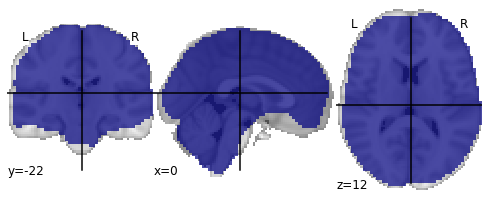

In [13]:
mask = image.load_img("data/fMRI_mask.nii")
plotting.plot_roi("data/fMRI_mask.nii")

* fMRI_train - a folder containing 53 3D spatial maps for train samples in .mat format _(only 2 samples has been taken from repo due to large size of .mat files)_

In [14]:
def load_subject(filename, mask_niimg):
    """
    Load a subject saved in .mat format with
        the version 7.3 flag. Return the subject
        niimg, using a mask niimg as a template
        for nifti headers.
        
    Args:
        filename    <str>            the .mat filename for the subject data
        mask_niimg  niimg object     the mask niimg object used for nifti headers
    """
    
    subject_data = None
    
    with h5py.File(filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_niimg = image.new_img_like(mask, subject_data, affine=mask.affine, copy_header=True)
    return subject_niimg


### Exploratory Data Analysis

#### Compoment spatial maps visualization

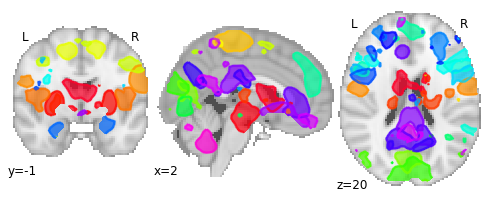

In [15]:
plotting.plot_prob_atlas(load_subject('data/fMRI_train/10002.mat', mask),
                         view_type='filled_contours',
                         draw_cross=False,
                         threshold='auto')

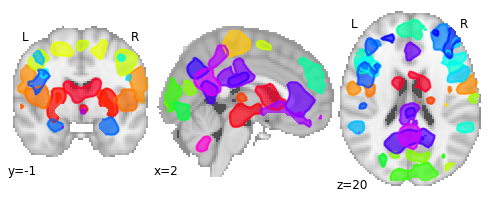

In [16]:
plotting.plot_prob_atlas(load_subject('data/fMRI_train/10009.mat', mask),
                         view_type='filled_contours',
                         draw_cross=False,
                         threshold='auto')

* fMRI_test - a folder containing 53 3D spatial maps for test samples in .mat format _(only 2 samples has been taken from repo due to large size of .mat files)_

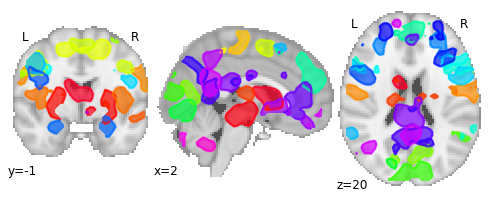

In [17]:
plotting.plot_prob_atlas(load_subject('data/fMRI_test/10003.mat', mask),
                         view_type='filled_contours',
                         draw_cross=False,
                         threshold='auto')

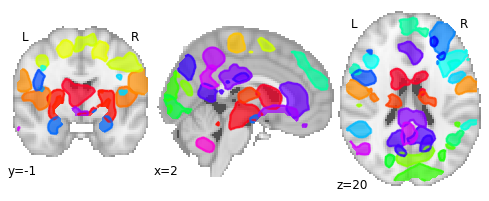

In [18]:
plotting.plot_prob_atlas(load_subject('data/fMRI_test/10016.mat', mask),
                         view_type='filled_contours',
                         draw_cross=False,
                         threshold='auto')

#### Brain age distribtion plot

Text(0, 0.5, 'Number of Occurrences')

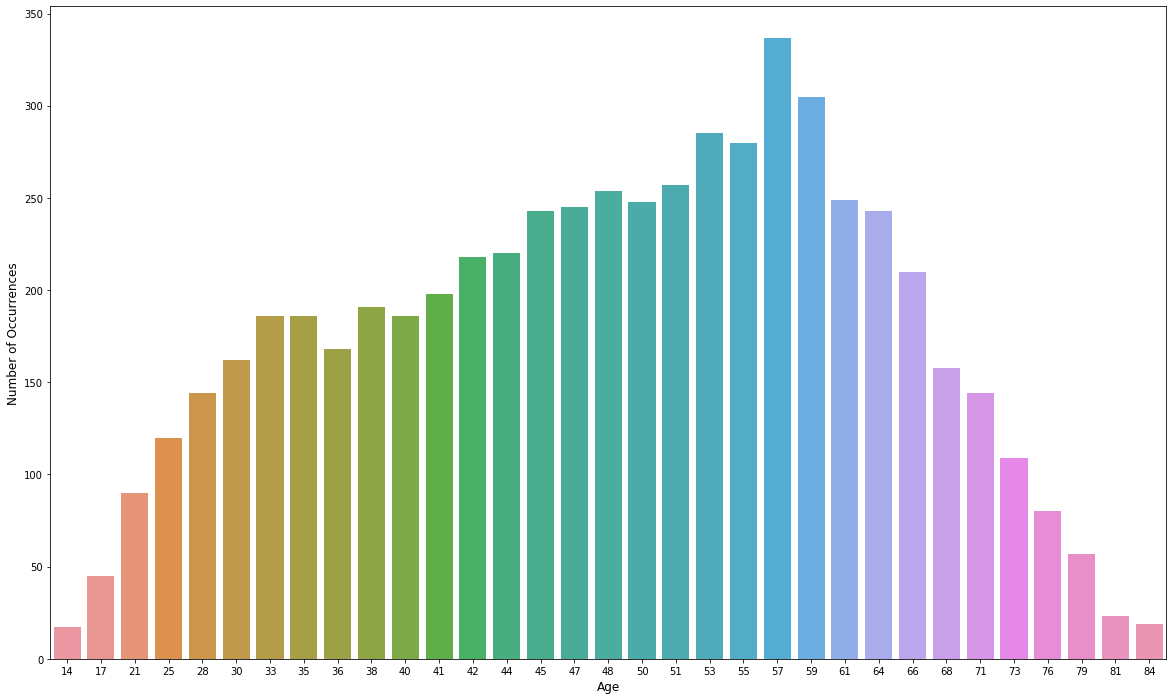

In [19]:
plt.figure(figsize=(20,12))
sns.barplot(train_scores['age'].astype(int).value_counts().index,
            train_scores['age'].astype(int).value_counts().values)

plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)

#### Plot the distributions of the training_scores set

Text(0.5, 0.98, 'Target distributions')

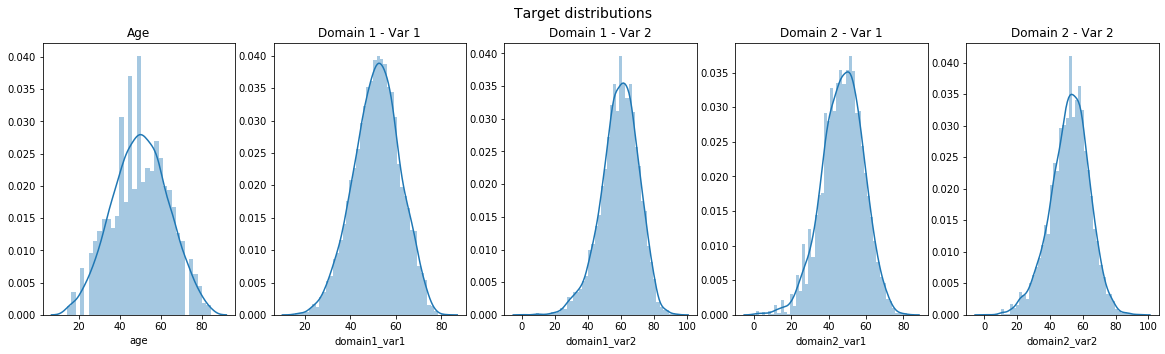

In [20]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.distplot(train_scores['age'], ax=ax[0])
ax[0].set_title('Age')

sns.distplot(train_scores['domain1_var1'].fillna(method='ffill'), ax=ax[1])
ax[1].set_title('Domain 1 - Var 1')

sns.distplot(train_scores['domain1_var2'].fillna(method='ffill'), ax=ax[2])
ax[2].set_title('Domain 1 - Var 2')

sns.distplot(train_scores['domain2_var1'].fillna(method='ffill'), ax=ax[3])
ax[3].set_title('Domain 2 - Var 1')

sns.distplot(train_scores['domain2_var2'].fillna(method='ffill'), ax=ax[4])
ax[4].set_title('Domain 2 - Var 2')

fig.suptitle('Target distributions', fontsize=14)

 The kurtosis of the training scores is small, meaning that there is not much weight in the tails.

In [21]:
train_scores.kurtosis()

Id             -1.209817
age            -0.362580
domain1_var1   -0.151687
domain1_var2    0.504195
domain2_var1    0.330433
domain2_var2    0.333461
dtype: float64

#### Check the correlation between age and features in training_scores

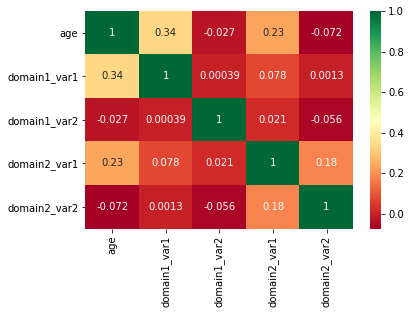

In [22]:
sns.heatmap(train_scores.drop('Id', axis=1).corr(), annot = True, cmap="RdYlGn")

#### Distribution of loading gray matter concentration maps from structural MRI (sMRI) scans.

Text(0.5, 1, 'Source-based morphometry loadings distribution')

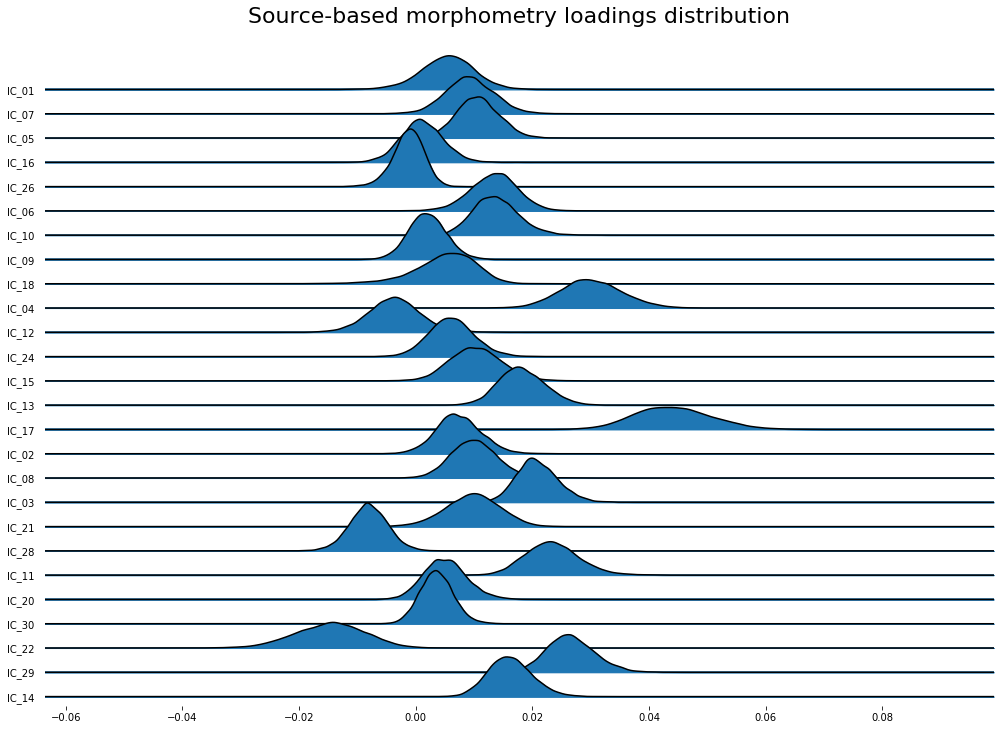

In [23]:
ax, fig = joypy.joyplot(loading_data.drop('Id', axis=1), figsize=(14,10))

plt.title('Source-based morphometry loadings distribution', fontsize=22)

#### Correlation of IC concentraion maps

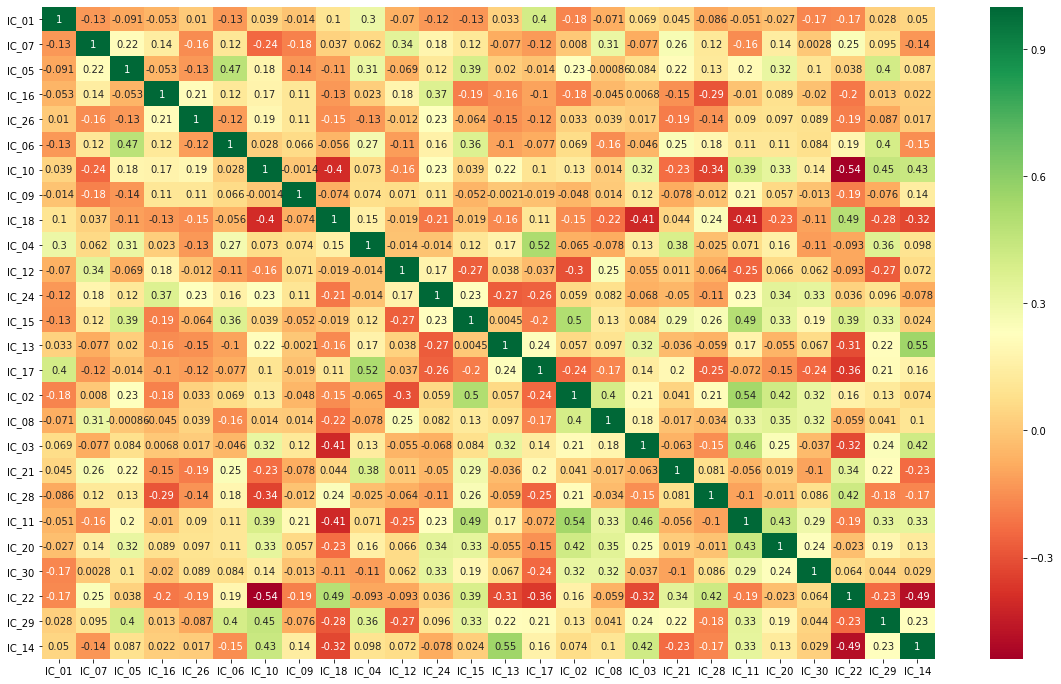

In [24]:
plt.figure(figsize=(20,12))
sns.heatmap(loading_data.drop('Id', axis=1).corr(), annot = True, cmap="RdYlGn")

### Feature Engineering

#### Process id_site to loading_data and fnc dimension by index and fill if the result is produced by different scanner

In [82]:
dataset = pd.DataFrame(fnc['Id'])
dataset['other_scanner'] = site["Id"].isin(id_site['Id'])
dataset['other_scanner'].astype(int, copy=False)

0        0
1        0
2        0
3        0
4        0
        ..
11749    0
11750    0
11751    0
11752    0
11753    0
Name: other_scanner, Length: 11754, dtype: int64

#### Giving less importance to FNC features since they are easier to overfit due to high dimensionality.

In [69]:
FNC_SCALE = 1/600

In [85]:
dataset = pd.concat([dataset, fnc.iloc[:,1:] * FNC_SCALE], axis=1)

#### Merging datasets

In [104]:
dataset = dataset.merge(loading_data, on="Id")
dataset

,Id,other_scanner,SCN(53)_vs_SCN(69),SCN(98)_vs_SCN(69),SCN(99)_vs_SCN(69),SCN(45)_vs_SCN(69),ADN(21)_vs_SCN(69),ADN(56)_vs_SCN(69),SMN(3)_vs_SCN(69),SMN(9)_vs_SCN(69),...,IC_08_y,IC_03_y,IC_21_y,IC_28_y,IC_11_y,IC_20_y,IC_30_y,IC_22_y,IC_29_y,IC_14_y
0,10001,False,0.000614,0.000278,0.000730,0.000568,-0.000310,0.000082,0.000202,-0.000290,...,0.018246,0.023711,0.009177,-0.013929,0.030696,0.010496,0.002892,-0.023235,0.022177,0.017192
1,10002,False,0.000253,-0.000041,0.000363,0.000697,-0.000379,-0.000107,-0.000240,-0.000197,...,0.014635,0.022556,0.012004,-0.011814,0.022479,0.005739,0.002880,-0.016609,0.025543,0.014524
2,10003,False,0.000572,0.000183,0.001236,0.000964,-0.001127,-0.000728,-0.000493,-0.000630,...,0.019565,0.030616,0.018184,-0.010469,0.029799,0.015435,0.005211,-0.028882,0.031427,0.018164
3,10004,False,0.000221,0.000430,0.000818,0.000571,0.000152,0.000180,0.000049,-0.000044,...,0.002658,0.022266,0.005956,-0.010595,0.024078,-0.000319,0.005866,-0.015182,0.024476,0.014760
4,10005,False,0.000487,0.000419,0.000694,0.000853,-0.000604,-0.000275,-0.000482,-0.000026,...,0.009702,0.017257,0.005454,-0.008591,0.019416,0.000786,0.002692,-0.019814,0.017105,0.013316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11749,21750,False,0.000380,-0.000371,0.000417,0.000738,-0.000368,-0.000392,-0.000494,-0.000455,...,0.011454,0.022840,0.006448,-0.007203,0.029689,0.004942,0.007751,-0.020226,0.028821,0.017492
11750,21751,False,0.000758,0.000806,0.000983,0.001056,0.000270,-0.000292,0.000026,0.000226,...,0.012303,0.018314,0.012326,-0.012152,0.024617,0.002096,0.001911,-0.008028,0.035093,0.017439
11751,21752,False,0.000197,0.000754,0.001014,0.000704,-0.000177,-0.000014,-0.000017,-0.000203,...,0.012055,0.020741,0.001160,-0.007140,0.025236,0.002026,0.001876,-0.014612,0.021665,0.019592
11752,21753,False,0.000085,0.000148,0.000919,0.000509,-0.000057,-0.000158,-0.000150,-0.000371,...,0.019220,0.026282,0.020715,-0.008130,0.025149,0.007695,0.003226,-0.003505,0.029326,0.014235


### Modeling

#### Creating train and test set

In [103]:
X_train = dataset.loc[dataset["Id"].isin(train_scores["Id"]) == True]
Y_train = train_scores
X_test = dataset.loc[dataset["Id"].isin(train_scores["Id"]) == False]